# Segment

In this notebook, we demonstrate and compare techniques for segmentation and classification of crops using Planet imagery. A metric will be established to quantify accuracy of crop classification and will be used to compare technique results.

## Usage Notes

This notebook was developed in a Docker container. This [Dockerfile](Dockerfile) was used to build the image.

This notebook expects that the following scene has been downloaded into the data sub-dir directory: '20160831_180231_0e0e_3B_AnalyticMS.tif'

In [16]:
from collections import namedtuple
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio

%matplotlib inline

## Load Image

Here we define the image path, check that it exists, then define some helper functions for loading the image. We don't actually load the image until later on to avoid running out of memory.

In [19]:
saved_file = os.path.join('data', '20160831_180231_0e0e_3B_AnalyticMS.tif')
assert os.path.isfile(saved_file)

In [25]:
# NOTE: Not sure a namedtuple is what we want long-term. It is used now because:
# memory footprint is smaller than a masked ndarray (where the same mask is repeated across all bands)
# response is faster than rasterio read(), which appears to read from the file vs. caching

# Saves the image bands and image mask separately
# Bands is a 16-bit ndarray representing band pixels
# Mask is a boolean 2d array identifying nodata pixels
MaskedImage = namedtuple('MaskedImage', 'bands, mask')

def load_masked_image(filename):
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
        return MaskedImage(bands=np.dstack([r, g, b, nir]), mask=mask)
# img = load_masked_image(saved_file)
# del img

def create_masked_array(masked_image):
    # recast 2d mask to 3d, repeating across 3rd axis
    mask = np.broadcast_to(np.atleast_3d(masked_image.mask),
                           masked_image.bands.shape)
    return ma.masked_array(masked_image.bands, mask)
# masked_img = create_masked_array(load_masked_image(saved_file))
# del masked_img

## Display Image

The image is 16-bit, 4-band, and contains nodata pixels defined by a mask. Matplotlib's `imshow()` function, which we use for display, expects a 3-band, 8-bit numpy array and has no concept of masks. Therefore, some processing and scaling is required for display.

In [27]:
def linear_scale(img, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (img - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def to_8_bit(img, old_min, old_max):
    """Converts the image to 8-bit using linear scaling and clipping to 8-bit min/max"""
    new_min = 0
    new_max = 2**8 - 1
    scaled = linear_scale(img.astype(np.double), old_min, old_max, new_min, new_max)
    return np.clip(scaled, new_min, new_max).astype(np.uint8)
print(to_8_bit(np.array([1,2,10,100,256,2560, 2660]), 2, 2560))

[ -1   0   0   9  25 256 266]
[  0   0   0   9  25 255 255]


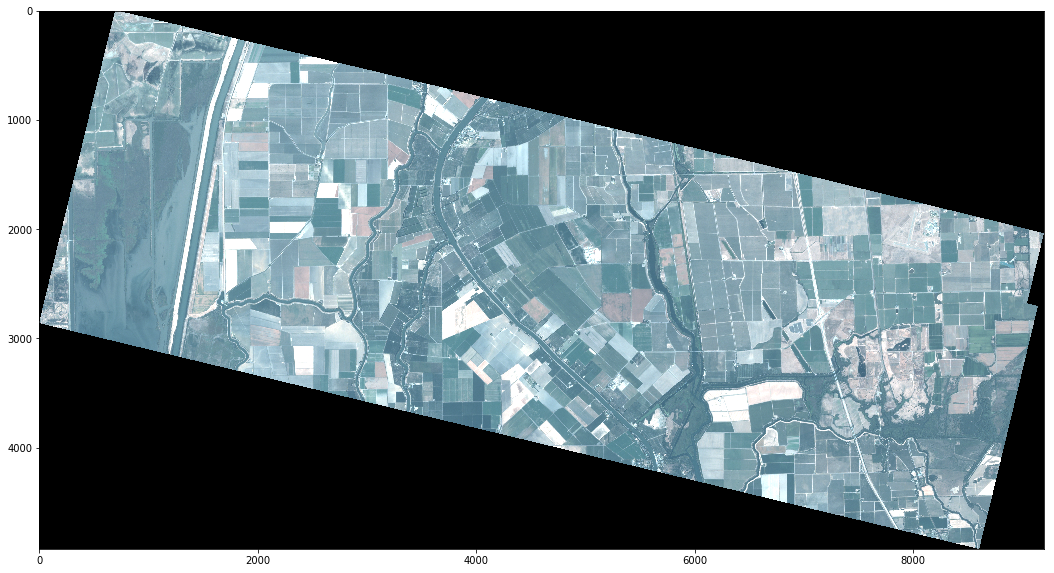

In [28]:
def to_display(masked_image):
    """Converts the masked image to a 3-band rgb, 8-bit array for display."""
    rgb_bands = create_masked_array(masked_image)[:,:,:3]
#     old_min = rgb_bands.min()
#     old_max = rgb_bands.max()
    old_min = np.percentile(rgb_bands, 2) # looks prettier than using the min val
    old_max = np.percentile(rgb_bands, 98) # looks prettier than using the max val
    return to_8_bit(rgb_bands, old_min, old_max)

plt.figure(1,figsize=(18,36))
plt.imshow(to_display(load_masked_image(saved_file)))